# How does volatility impact returns - part 1
I was talking with a friend yesterday who told me that, given 2 mutual funds with equal average interest rates, the one that has less volatility gets you more money in the long run. This is a Monte Carlo simulation to test that hypothesis.

#### We'll do a few tests:

Test 1: Does volatility of investments affect expected returns?

Test 2: Does volatility of investments affect the probability of reaching various financial goals?

Test 3: Is it better to invest in higher-risk things while young and go lower-risk when you get older?

## Test 1: Does volatility of investments affect expected returns?
#### Constants between scenarios:

30 years

Adding 5,500 per year to fund

Starting with $0 in the beginning

#### First, we'll these test 3 mutual funds:

mean of 8% return per year, and standard deviation of 2%

mean of 8% return per year, and standard deviation of 10%

mean of 8% return per year, and standard deviation of 30%

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Graphing helper function
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## Return rates
First, we need a way to generate the return rates for each mutual fund. We'll do this by sampling a normal distribution with these properties:

1. mean = average return of mutual fund

2. standard deviation = standard deviation of mutual fund

In [3]:
def generate_return_rates(return_mean, return_std, years):
    return return_mean + return_std * np.random.randn(years)

### Example of what rate of returns looks like

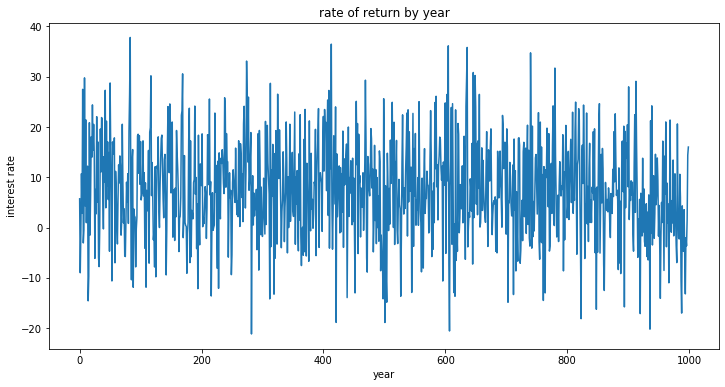

In [4]:
return_rates = generate_return_rates(8, 10, 1000)
year_range = range(1000)
setup_graph(title='rate of return by year', x_label='year', y_label='interest rate', fig_size=(12,6))
plt.plot(year_range, return_rates)

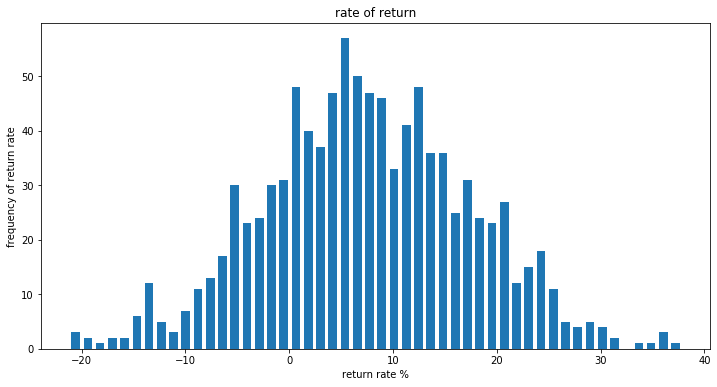

In [5]:
hist, bins = np.histogram(return_rates, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
setup_graph(title='rate of return', x_label='return rate %', y_label='frequency of return rate', fig_size=(12,6))
plt.bar(center, hist, align='center', width=width)
plt.show()

## Investment returns
Now we need a way to calculate fund returns given the sequence of return rates and the sequence of how much is contributed per year.

We'll make the following assumptions to simplify:

- Compound interest just once per year
- Contribute the same amount each year, just one time per year
- Ignore inflation

In [6]:
def calculate_fund_returns(contribution_per_year, returns_by_year, starting_principal=0):
    """ Calculate the fund returns for the sequence of years given.
    
    Parameters:
        * contributsions_per_year - float representing dollars contributed per year
        * returns_by_year - list of percent returns per year like [.1, -.05, ...].
    Returns the fund value by year - a list like this:
        [1000, 1026.25, 1223.75, 1100.75, ...]
    """
    principal = starting_principal
    value_by_year = []
    for return_rate in returns_by_year:
        # Add the contribution first thing each year
        principal = principal + contribution_per_year
        
        # Calculate growth/loss
        principal = principal * (1 + return_rate)
        
        value_by_year.append(principal)

    return value_by_year

#### Let's test to make sure this function seems to work¶
7/10 rule - we should double our money at 7% interest in 10 years

In [7]:
calculate_fund_returns(0, [0.07]*10, 1000)

[1070.0,
 1144.9,
 1225.0430000000001,
 1310.7960100000003,
 1402.5517307000005,
 1500.7303518490005,
 1605.7814764784307,
 1718.186179831921,
 1838.4592124201556,
 1967.1513572895667]

In [8]:
1000 * 1.07

1070.0

In [9]:
1070 * 1.07

1144.9

Our function looks good.

So now, let's look at our first 2 scenarios..

## Mutual Fund 1: 8% return, 2% standard deviation

In [10]:
years = range(30)
m1_return_rates = [percent / 100 for percent in generate_return_rates(8, 2, 30)]
m1_value_by_year = calculate_fund_returns(5500, m1_return_rates)

In [11]:
m1_value_by_year

[5999.247836041936,
 12498.810378248107,
 19502.876145006085,
 26857.372886832964,
 35603.002061107436,
 44595.652274423985,
 53325.580167136955,
 64045.04062501177,
 73114.84352180723,
 83234.5160525647,
 98066.80408028506,
 112795.8926679992,
 127403.98052648384,
 144875.87227919867,
 158293.7795282609,
 177493.97881140263,
 196034.32465394892,
 215340.06837275068,
 243338.85371744348,
 266382.1765784751,
 292973.12995696673,
 319601.2918979599,
 342006.0541026853,
 374040.3229438439,
 422250.15801927575,
 443408.0117505525,
 490383.4571854377,
 540142.1360847366,
 570192.1566940038,
 631163.5246665409]

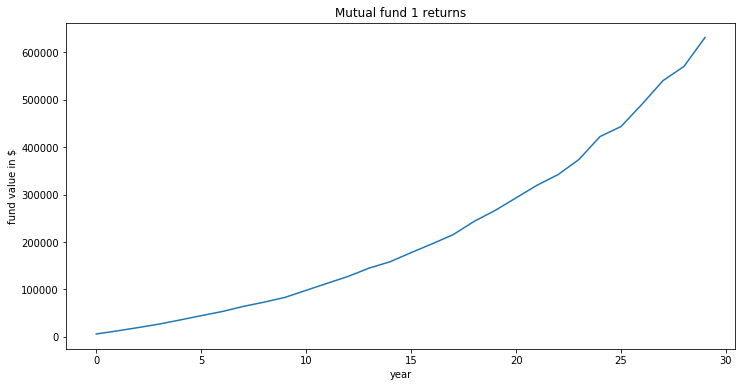

In [12]:
setup_graph(title='Mutual fund 1 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, m1_value_by_year)

So this is what fund 1 looks like. But we want to do more than 1 simulation. Let's do 100,000 simulations and find what the average ending value is.

In [13]:
def find_average_fund_return(return_mean, return_std, years, addition_per_year, num_trials):
    return_total = 0
    for i in range(num_trials):
        m1_return_rates = [percent / 100 for percent in generate_return_rates(return_mean, return_std, years)]
        m1_value_by_year = calculate_fund_returns(addition_per_year, m1_return_rates)
        final_return = m1_value_by_year[-1]  # [-1] gets the last element in the list
        return_total += final_return
    return return_total / num_trials

In [14]:
m1_average_final_value = find_average_fund_return(8, 2, 30, 5500, 100000)
m1_average_final_value

673124.5138143597

In [15]:
def percent_to_decimal(percent_iterator):
    for p in percent_iterator:
        yield p / 100

num_trials = 100000
returns_per_trial = (calculate_fund_returns(5500, percent_to_decimal(generate_return_rates(8, 2, 30)))[-1] for i in range(num_trials))
avg_returns = sum(returns_per_trial) / num_trials
avg_returns

672799.4502460706

## Mutual Fund 2: 8% return, 10% standard deviation

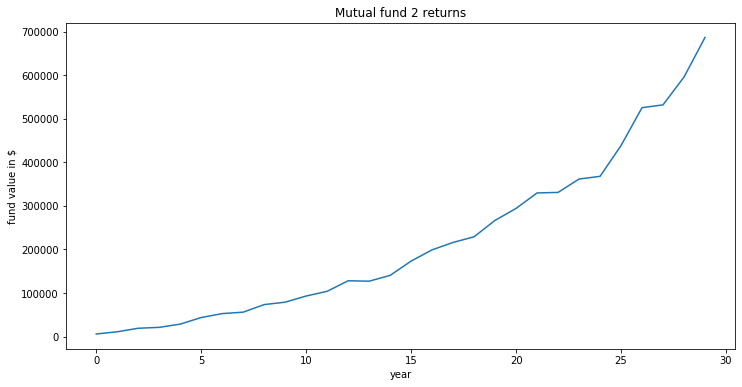

In [16]:
m2_return_rates = [percent / 100 for percent in generate_return_rates(8, 10, 30)]
m2_value_by_year = calculate_fund_returns(5500, m2_return_rates)
setup_graph(title='Mutual fund 2 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, m2_value_by_year)

In [17]:
m2_average_final_value = find_average_fund_return(8, 10, 30, 5500, 100000)
m2_average_final_value

673067.0882432836

This looks almost exactly the same as Mutual Fund 1. Let's try more extreme standard deviations: 30%...

## Mutual fund 3: 8% mean interest, 30% standard deviation

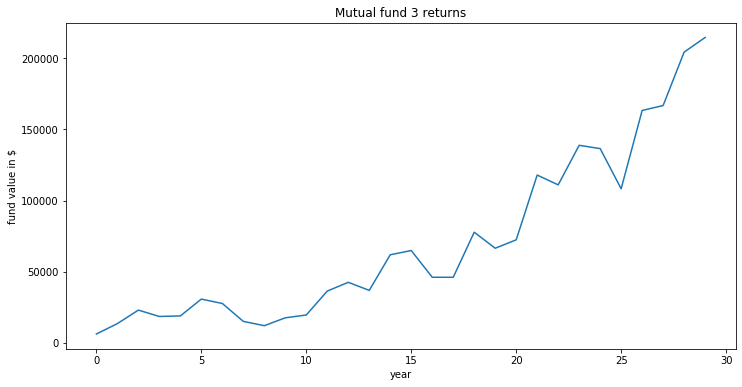

In [18]:
m3_return_rates = [percent / 100 for percent in generate_return_rates(8, 30, 30)]
m3_value_by_year = calculate_fund_returns(5500, m3_return_rates)
setup_graph(title='Mutual fund 3 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, m3_value_by_year)

In [19]:
m3_average_final_value = find_average_fund_return(8, 30, 30, 5500, 100000)
m1_average_final_value

673124.5138143597

## Conclusion
30% is pretty volatile, and yet, it's still very close to the returns on the less volatile funds. So this demonstrates that lower volatility does not necessarily get better returns. <b>Instead, it appears that the volatility does not change what your expected return will be.</b>

So the outcomes of running 100,000 simulations for the mutual funds were:

In [20]:
print('Fund 1 (8% mean, 2% standard dev) = {}'.format(m1_average_final_value))
print('Fund 2 (8% mean, 10% standard dev) = {}'.format(m2_average_final_value))
print('Fund 3 (8% mean, 30% standard dev) = {}'.format(m3_average_final_value))

Fund 1 (8% mean, 2% standard dev) = 673124.5138143597
Fund 2 (8% mean, 10% standard dev) = 673067.0882432836
Fund 3 (8% mean, 30% standard dev) = 672764.850844634



# Test 2: 
# Does volatility of investments affect the probability of reaching various financial goals?
However, what if you want to know the probability of having at least some amount of money at retirement? How does volatility affect those goals? Let's find out.

Let's say you want at least $600,000 to retire. What's the probability of reaching at least that with each of our 3 hypothetical mutual funds?

In [21]:
def find_probability_of_reaching_goal(return_mean, return_std, years, addition_per_year, num_trials, goal):
    reached_goal = 0
    for i in range(num_trials):
        m1_return_rates = [percent / 100 for percent in generate_return_rates(return_mean, return_std, years)]
        m1_value_by_year = calculate_fund_returns(addition_per_year, m1_return_rates)
        final_return = m1_value_by_year[-1]  # [-1] gets the last element in the list
        if final_return >= goal:
            reached_goal += 1
    return reached_goal / num_trials

In [22]:
m1_probability_of_reaching_600000 = find_probability_of_reaching_goal(8, 2, 30, 5500, 100000, 600000)
m1_probability_of_reaching_600000

0.93039

In [23]:
m2_probability_of_reaching_600000 = find_probability_of_reaching_goal(8, 10, 30, 5500, 100000, 600000)
m2_probability_of_reaching_600000

0.54198

In [24]:
m1_probability_of_reaching_600000 = find_probability_of_reaching_goal(8, 30, 30, 5500, 100000, 600000)
m1_probability_of_reaching_600000

0.31095

## Conclusion 2
Wow, so the probability of reaching at least $600,000 for retirement if you go with:

- the 2% standard deviation mutual fund has a 93% probability of reaching 600,000 dollars
- the 10% standard deviation mutual fund has a 54% probability of reaching 600,000 dollars
- the 30% standard deviation mutual fund has a 30% probability of reaching 600,000 dollars

<b>So if you need to make sure you reach a certain amount, then it probabily is better to go with lower volatility investments.</b>

## Test 3: 
## Is it better to invest in higher-risk things while young and go lower-risk when you get older?
Common advice is to do more high-risk investments when you're young, and transition to lower-risk investments when you get older.

From the previous conclusions, I suspect doing lower-risk investments when you're older is better, but what about when you're young? Should you do higher-risk or lower-risk investments when you're young?

#### To test this, we'll do a Monte Carlo simulation where we'll compare 4 mutual funds:

Fund 1:
- years 1-10: 8% mean return, 4% standard deviation
- years 11-20: 6% mean return, 3% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

Fund 2:
- years 1-10: 8% mean return, 10% standard deviation
- years 11-20: 6% mean return, 5% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

Fund 3:
- years 1-10: 8% mean return, 30% standard deviation
- years 11-20: 6% mean return, 5% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

Fund 4:
- years 1-10: 8% mean return, 30% standard deviation
- years 11-20: 6% mean return, 10% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

<b>So these 4 funds range in volatility, especially in the first 10 years, but all end in a low-volatility strategy in the last 10 years.</b>

## Fund 1
- years 1-10: 8% mean return, 4% standard deviation
- years 11-20: 6% mean return, 3% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

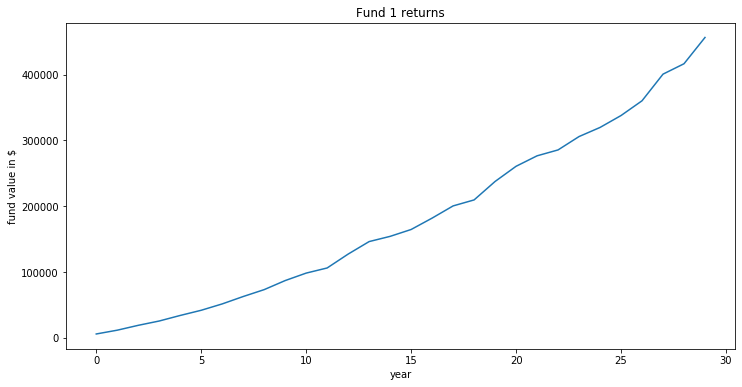

In [25]:
def get_fund1_returns():
    fund1_return_rates = [percent / 100 for percent in generate_return_rates(8, 4, 10)] + \
                         [percent / 100 for percent in generate_return_rates(6, 3, 10)] + \
                         [percent / 100 for percent in generate_return_rates(4, 2, 10)]
    fund1_value_by_year = calculate_fund_returns(5500, fund1_return_rates)
    return fund1_value_by_year

setup_graph(title='Fund 1 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, get_fund1_returns())

## Fund 2
- years 1-10: 8% mean return, 10% standard deviation
- years 11-20: 6% mean return, 5% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

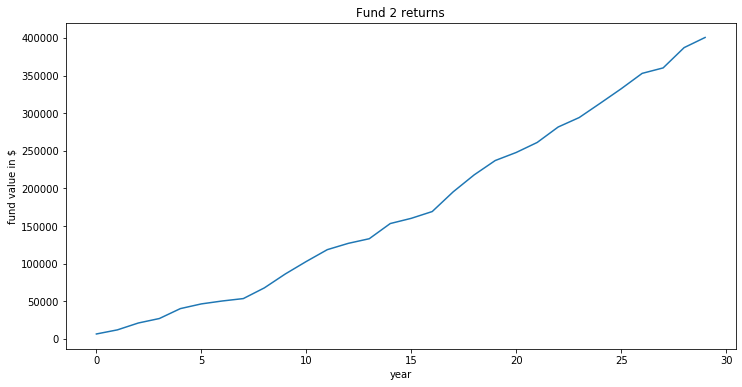

In [26]:
def get_fund2_returns():
    fund_return_rates = [percent / 100 for percent in generate_return_rates(8, 10, 10)] + \
                        [percent / 100 for percent in generate_return_rates(6, 5, 10)] + \
                        [percent / 100 for percent in generate_return_rates(4, 2, 10)]
    fund_value_by_year = calculate_fund_returns(5500, fund_return_rates)
    return fund_value_by_year

setup_graph(title='Fund 2 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, get_fund2_returns())

## Fund 3
- years 1-10: 8% mean return, 30% standard deviation
- years 11-20: 6% mean return, 5% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

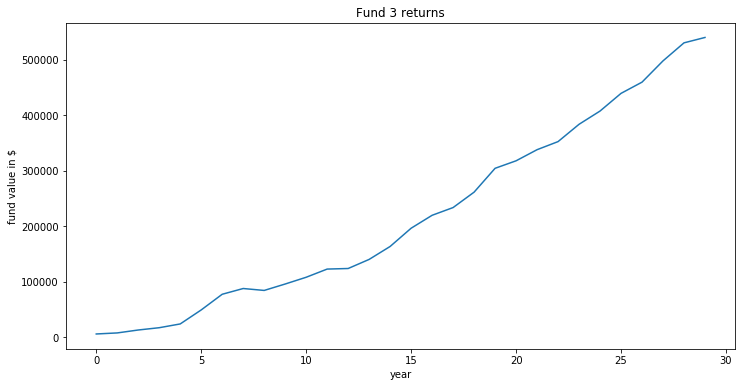

In [27]:
def get_fund3_returns():
    fund_return_rates = [percent / 100 for percent in generate_return_rates(8, 30, 10)] + \
                        [percent / 100 for percent in generate_return_rates(6, 5, 10)] + \
                        [percent / 100 for percent in generate_return_rates(4, 2, 10)]
    fund_value_by_year = calculate_fund_returns(5500, fund_return_rates)
    return fund_value_by_year

setup_graph(title='Fund 3 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, get_fund3_returns())

## Fund 4
- years 1-10: 8% mean return, 30% standard deviation
- years 11-20: 6% mean return, 10% standard deviation
- years 21-30: 4% mean return, 2% standard deviation

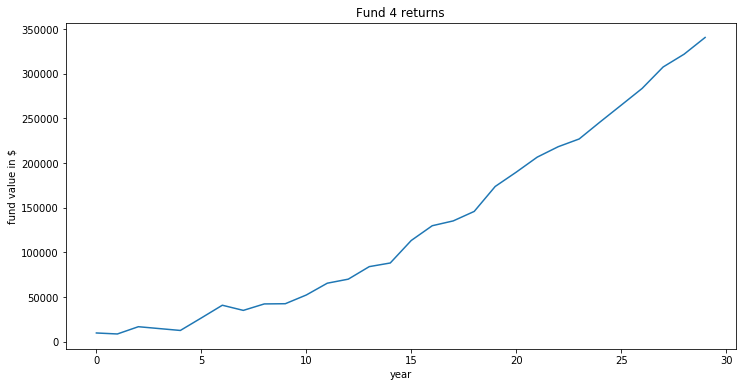

In [28]:
def get_fund4_returns():
    fund_return_rates = [percent / 100 for percent in generate_return_rates(8, 30, 10)] + \
                        [percent / 100 for percent in generate_return_rates(6, 10, 10)] + \
                        [percent / 100 for percent in generate_return_rates(4, 2, 10)]
    fund_value_by_year = calculate_fund_returns(5500, fund_return_rates)
    return fund_value_by_year

setup_graph(title='Fund 4 returns', x_label='year', y_label='fund value in $', fig_size=(12,6))
plt.plot(years, get_fund4_returns())

### Now let's compare the average returns for each fund by running 100,000 simulations for each fund

In [29]:
num_trials = 100000
fund1_trial_returns = [get_fund1_returns()[-1] for i in range(num_trials)]
fund1_avg_returns = sum(fund1_trial_returns) / num_trials
fund1_avg_returns

410534.43795121775

In [30]:
fund2_trial_returns = [get_fund2_returns()[-1] for i in range(num_trials)]
fund2_avg_returns = sum(fund2_trial_returns) / num_trials
fund2_avg_returns

410165.67152507586

In [31]:
fund3_trial_returns = [get_fund3_returns()[-1] for i in range(num_trials)]
fund3_avg_returns = sum(fund3_trial_returns) / num_trials
fund3_avg_returns

410212.60173819074

In [32]:
fund4_trial_returns = [get_fund4_returns()[-1] for i in range(num_trials)]
fund4_avg_returns = sum(fund4_trial_returns) / num_trials
fund4_avg_returns

410394.79573405464

As I was expecting, the expected returns is almost identical for each of the funds. But let's see what the probability is of, say, reaching $400,000 for each fund...

In [33]:
len([i for i in fund1_trial_returns if i >= 400000]) / num_trials

0.58691

In [34]:
len([i for i in fund2_trial_returns if i >= 400000]) / num_trials

0.51806

In [35]:
len([i for i in fund3_trial_returns if i >= 400000]) / num_trials

0.41657

In [36]:
len([i for i in fund4_trial_returns if i >= 400000]) / num_trials

0.4079


#### So it looks like your probability of reaching $400,000 in this scenario with the less volatile funds, even in the early years.

#### What about reaching a higher number, like $500,000?

In [37]:
len([i for i in fund1_trial_returns if i >= 500000]) / num_trials

0.01903

In [38]:
len([i for i in fund2_trial_returns if i >= 500000]) / num_trials

0.09981

In [39]:
len([i for i in fund3_trial_returns if i >= 500000]) / num_trials

0.20765

In [40]:
len([i for i in fund4_trial_returns if i >= 500000]) / num_trials

0.21991

#### Interesting, so the probabilities inverse here - there's only a 2% chance of reaching 500,000 if you have the less volatile funds, but a 20% chance of reaching 500,000 with the more volatile funds. This affirms the aphorism, "higher risk = higher reward".